<b> Optimizacion Industrial con Computacion Evolutiva </b>

Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial

- Antonio Jesus Supanta Supanta
- Cinthya Silvana Carhuayo Bendezu


# DESAFIO: Algoritmo Genetico para resolver el problema de localizaciones optimas de una cadena de supermercados

Una reconocida cadena de supermercados está evaluando su ingreso al mercado limeño. Como parte del equipo de análisis, se nos ha encomendado diseñar una propuesta sobre dónde ubicar 10 nuevos supermercados dentro de la ciudad de Lima.

Para ello, contamos con:
- Un conjunto de 60 ubicaciones candidatas distribuidas por la ciudad.
- Una tabla con:
  - Las coordenadas geográficas de cada local candidato.
  - La población estimada en un radio de 500 metros alrededor de cada ubicación.

Se puede acceder a los datos desde el siguiente enlace: https://drive.google.com/open?id=1w7n77ByWK6TrX74lOBTwID719LRj_UQz&usp=sharing

El objetivo es seleccionar 10 ubicaciones de entre las 60 candidatas, de manera que se maximicen simultáneamente:
1. La suma de la población en un radio de 500 metros alrededor de los supermercados seleccionados.
2. La suma de las distancias en línea recta entre todos los pares de supermercados elegidos (promoviendo su distribución geográfica).

Además, se cuenta con al siguiente restricción:
- Distancia mínima: cualquier par de supermercados seleccionados debe estar separado por al menos 1 km en línea recta

Este problema será abordado utilizando algoritmos genéticos.

### Descarga del dataset

In [18]:
!wget -O Candidatos_supermercados.xlsx "https://raw.githubusercontent.com/A29S-PE/Proyecto_Computacion-Evolutiva/a526cfa65c3b7c0eacc88913e1ef754932dd9982/Candidatos_supermercados.xlsx"

--2025-09-03 03:30:52--  https://raw.githubusercontent.com/A29S-PE/Proyecto_Computacion-Evolutiva/a526cfa65c3b7c0eacc88913e1ef754932dd9982/Candidatos_supermercados.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12448 (12K) [application/octet-stream]
Saving to: ‘Candidatos_supermercados.xlsx’

Candidatos_supermer 100%[===================>]  12.16K  --.-KB/s    in 0s      

2025-09-03 03:30:52 (78.6 MB/s) - ‘Candidatos_supermercados.xlsx’ saved [12448/12448]



### Librerias a usar

In [1]:
import sys
import time
import random
import numpy as np
from itertools import combinations, product
from copy import deepcopy
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

### Estructura de una localizacion en el problema

In [2]:
class Localization(object):
    def __init__(self, description, coords, population):
        self.description = description
        self.coords  = coords  # Coordenadas de la localizacion.
        self.population = population # Poblacion en un radio de 500m de la localizacion.

### Estructura de individuo en el problema
Clase que implementa el individuo y sus operadores. El cromosoma corresponde a una solución candidata compuesta por 10 genes, donde cada gen correspondió a una localización seleccionada. En este contexto, los alelos correspondieron a las posibles ubicaciones disponibles, siendo en total 60 alelos que representaban las 60 localizaciones candidatas. De esta manera, cada cromosoma describía un subconjunto de 10 ubicaciones en las que se instalarían los supermercados

    Por ejemplo, si la cadena elige las localizaciones 21, 4, 7, 32, 9, 6, 1, 59, 12 y 25:    [21,4,7,32,9,6,1,59,12,25]


In [3]:
class Individual(object):

    def __init__(self, chromosome):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_orderpermutation(self, other):
        """
        Uniform order-based crossover. Genera 2 cromosomas hijos que tambien deben ser permutaciones
        Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other
        Escoge aleatoriamente la mitad de posiciones del cromosoma self y lo copia a un hijo ind1 en las mismas posiciones
        Los numeros faltantes los copia de other en el mismo orden en que aparecen en other
        El hijo ind2 se crea de la misma forma intercambiando self por other
        """

        pos_constantes = []
        pos_constantes = random.sample(range(len(self.chromosome)),len(self.chromosome)//2)
        cromosomo1 = [-1]*len(self.chromosome)
        cromosomo2 = [-1]*len(self.chromosome)

        for index in pos_constantes:
            cromosomo1[index]= self.chromosome[index]
            cromosomo2[index] = other.chromosome[index]


        for i in range(len(self.chromosome)):
            if(cromosomo1[i] == -1):
                for j in range(len(other.chromosome)):
                    if other.chromosome[j] not in cromosomo1:
                        cromosomo1[i] = other.chromosome[j]
                        break

                for j in range(len(self.chromosome)):
                    if self.chromosome[j] not in cromosomo2:
                        cromosomo2[i] = self.chromosome[j]
                        break

        ind1 = Individual(cromosomo1)
        ind2 = Individual(cromosomo2)
        return [ind1, ind2]

    def crossover_intersection_union(self, other):
        """
        Intersection-Union based crossover. Genera 2 cromosomas hijos que también deben ser permutaciones
        Retorna dos nuevos individuos del cruzamiento basado en conjuntos entre self y other
        Los genes comunes entre ambos padres (intersección) se copian directamente en los hijos
        Los genes faltantes se completan con elementos de la unión de ambos padres que no son genes comunes
        """
        set1 = set(self.chromosome)
        set2 = set(other.chromosome)

        inter = set1 & set2
        union = list(set1 | set2)

        rest = [g for g in union if g not in inter]
        random.shuffle(rest)

        cromosomo1 = list(inter) + rest[:(len(self.chromosome) - len(inter))]
        cromosomo2 = list(inter) + rest[::-1][:(len(self.chromosome) - len(inter))]

        ind1 = Individual(cromosomo1)
        ind2 = Individual(cromosomo2)
        return [ind1, ind2]

    def mutate_replacement(self, localizationsPool):
        mutated_chromosome = deepcopy(self.chromosome[:])
        i = random.randrange(len(mutated_chromosome))
        available = list(set(localizationsPool.keys()) - set(mutated_chromosome))
        mutated_chromosome[i] = random.choice(available)
        return Individual(mutated_chromosome)

### Funciones generales

Funcion para calcular distancia entre dos localizaciones (en km)

In [4]:
def haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    R = 6371

    distancia = R * c
    return distancia

Función para validar si un cromosoma tiene un par de localizaciones cercanos a menos de 1km de distancia

*(Se usará en los resultados finales)*

In [5]:
def has_close_pairs(chromosome, LocalizationsPool):
    pares = combinations(chromosome, 2)
    for loc1, loc2 in pares:
        coords1 = LocalizationsPool[loc1].coords
        coords2 = LocalizationsPool[loc2].coords
        dist = haversine(coords1, coords2)
        if dist < 1:
          return True
    return False

Funcion para cargar el pool de localizaciones por medio del excel

In [6]:
def load_localizationPool(path):
    localizations = pd.read_excel('Candidatos_supermercados.xlsx')
    localizations['Name'] = localizations['ID'].str.split().str[1]
    localizations.index   = localizations['Name'].astype(int)
    localizations['Coords'] = list(zip(localizations['Latitud'], localizations['Longitud']))
    localizations['Poblacion500m'] = localizations['Poblacion500m'].astype(int)
    localizationsPool = {}
    for idx, row in localizations.iterrows():
        loc = Localization(
            description=row['Descripcion'],
            coords=row['Coords'],
            population=row['Poblacion500m']
        )
        localizationsPool[idx] = loc
    return localizationsPool

Funcion para inicializar una poblacion

In [7]:
def init_population(popsize, chromosome_size, LocalizationsPool):
    population = []
    locs = list(LocalizationsPool.keys())

    while len(population) < popsize:
        while True:
            new_chromosome = random.sample(locs, chromosome_size)
            pares = combinations(new_chromosome, 2)

            # Se Verifica si alguna distancia entre pares es menor a 1km
            if all(haversine(LocalizationsPool[loc1].coords, LocalizationsPool[loc2].coords) >= 1 for loc1, loc2 in pares):
                # Si pasa la restricción, se agrega el individuo
                population.append(Individual(new_chromosome))
                break
            else:
                # Si no pasa la restricción, se genera un nuevo individuo
                pass

    return population

Funcion para mostrar una poblacion y su fitness

In [8]:
def display_population(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

### Funcion de Fitness

Funcion para evaluar el fitness de un Cromosoma

(Se ha colocado 3 elementos en el fitness, el primero es el fitness mono-objetivo, mientras que los 2 siguientes son los fitness para el multiobjetivo)

In [9]:
def fitness_localizations(chromosome, LocalizationsPool):
    """Retorna el fitness de un cromosoma en el problema de localizaciones"""
    fitness = np.zeros(3)
    total_pop = 0
    total_dist = 0

    for e in chromosome:
      total_pop += LocalizationsPool[e].population

    restriccion = False

    pares = combinations(chromosome, 2)
    for loc1, loc2 in pares:
        coords1 = LocalizationsPool[loc1].coords
        coords2 = LocalizationsPool[loc2].coords
        dist = haversine(coords1, coords2)
        if dist < 1:
          restriccion = True
          break
        else:
          total_dist += dist

    fitness[0] = total_pop + total_dist if restriccion == False else 1
    fitness[1] = total_dist if restriccion == False else 1
    fitness[2] = total_pop
    return fitness

Funcion para evaluar toda una población de individuos con la funcion de fitness especificada

In [10]:
def evaluate_population(population, fitness_fn, LocalizationsPool):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome, LocalizationsPool)
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [11]:
def select_parents_roulette(population):
    popsize = len(population)

    # Escoje el primer padre
    sumfitness = sum([indiv.fitness[0] for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness[0]
        if cumfitness > pickfitness:
            iParent1 = i
            break

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness[0] # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre
        cumfitness += population[i].fitness[0]
        if cumfitness > pickfitness:
            iParent2 = i
            break
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [12]:
def select_parents_torneo(population,size_torneo):

    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population))
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness[0])

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness[0])
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

## ALGORITMO GENETICO MONO-OBJETIVO

### Operador de seleccion de sobrevivientes

#### Seleccion de sobrevivientes por ranking

In [ ]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness[0], reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico

In [ ]:
def genetic_algorithm_mono(poblacion_inicial, fitness_fn, localizationsPool, ngen=100, pmut=0.2, tournament_size=3,
                      crossover="orderpermutation", mutation="swap",
                      selection_parents_method="roulette",
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico Mono Objetivo para el problema de localizaciones
        ngen:       maximo numero de generaciones
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes
    """
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial

    popsize = len(population)

    # Evalua la poblacion inicial
    evaluate_population(population, fitness_fn, localizationsPool)

    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness[0], reverse=True)[:1]
    best_fitness_per_gen = [population[ibest[0]].fitness]
    best_chromosome_per_gen = [population[ibest[0]].chromosome]
    # print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))

    for g in range(ngen):   # Por cada generacion

        ## Selecciona las parejas de padres (mating pool) para cruzamiento
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population))
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        else:
            raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "orderpermutation":
                offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
            elif crossover == "intersectionunion":
                offspring_population.extend( mating_pool[i][0].crossover_intersection_union(mating_pool[i][1]) )
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut:
                if mutation == "replacement":
                    offspring_population[i] = offspring_population[i].mutate_replacement(localizationsPool)      # mutacion replacement
                else:
                    raise NotImplementedError

        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn, localizationsPool)

        ## Selecciona popsize individuos para la sgte. generación
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness[0], reverse=True)[:1]
        best_fitness_per_gen.append(population[ibest[0]].fitness)
        best_chromosome_per_gen.append(population[ibest[0]].chromosome)

    return best_chromosome_per_gen, best_fitness_per_gen

### Probando el Algoritmo genetico

Se probara con las distintas configuraciones posibles, usando el pmut por defecto de 0.2 y tournamet_size 3 en caso se utilice este método de seleccion

In [ ]:
NUM_RUNS = 10

size_chromosoma = 10
num_individuals = 100
GENERATIONS = 500

localizationsPool = load_localizationPool('Candidatos_supermercados.xlsx')

list_crossover = ['orderpermutation','intersectionunion']
list_mutation = ['replacement']
list_selection_parents_method = ['roulette','tournament']
list_selection_survivors_method = ['ranking']

configs = list(product(
    list_crossover,
    list_mutation,
    list_selection_parents_method,
    list_selection_survivors_method
))

print(f"Total combinaciones: {len(configs)}")

Total combinaciones: 4


In [ ]:
results_mono = {config: {'fitness': [], 'generation': [], 'best_chromosome': []} for config in configs}

for run in range(NUM_RUNS):
    poblacion_inicial = init_population(num_individuals, size_chromosoma, localizationsPool)
    print('Corrida:', run)
    for config in configs:
        crossover, mutation, selection_parents, selection_survivors = config

        best_chromosome_per_gen, best_fitness_per_gen = genetic_algorithm_mono(
            poblacion_inicial=poblacion_inicial,
            fitness_fn=fitness_localizations,
            localizationsPool = localizationsPool,
            ngen=GENERATIONS,
            pmut=0.2,
            tournament_size=3,
            crossover=crossover,
            mutation=mutation,
            selection_parents_method=selection_parents,
            selection_survivors_method=selection_survivors
        )
        mono_fitness_max     = max(arr[0] for arr in best_fitness_per_gen)
        gen_convergence = next(i for i, arr in enumerate(best_fitness_per_gen) if arr[0] == mono_fitness_max)
        fitness_max     = best_fitness_per_gen[gen_convergence]
        best_chromosome = best_chromosome_per_gen[gen_convergence]
        results_mono[config]['fitness'].append(fitness_max)
        results_mono[config]['generation'].append(gen_convergence)
        results_mono[config]['best_chromosome'].append(best_chromosome)

Corrida: 0
Corrida: 1
Corrida: 2
Corrida: 3
Corrida: 4
Corrida: 5
Corrida: 6
Corrida: 7
Corrida: 8
Corrida: 9


In [ ]:
data = []

for config, vals in results_mono.items():
    for run_idx, (fit, gen, best_chromosome) in enumerate(zip(vals['fitness'], vals['generation'], vals['best_chromosome'])):
        data.append({
            'crossover': config[0],
            'mutation': config[1],
            'selection_parents': config[2],
            'selection_survivors': config[3],
            'run': run_idx,
            'fitness': fit,
            'generation': gen,
            'best_chromosome': best_chromosome
        })

df_resultados_mono = pd.DataFrame(data)

In [ ]:
print(len(df_resultados_mono))

40


Se pueden observar las mejores soluciones obtenidas por el algoritmo, en este caso al ser combinaciones de localizaciones, muchas de ellas se repiten ya que solo cambian el orden de los alelos

In [ ]:
fitness_df = pd.DataFrame(df_resultados_mono['fitness'].tolist(), columns=['fitness', 'suma de distancias (km)', 'poblacion atendida'])
df_resultados_mono = pd.concat([df_resultados_mono.drop(columns=['fitness']), fitness_df], axis=1)
df_resultados_mono.sort_values(by=['fitness', 'generation'], ascending=[False,True]).head(10)

,crossover,mutation,selection_parents,selection_survivors,run,generation,best_chromosome,fitness,suma de distancias (km),poblacion atendida
36,intersectionunion,replacement,tournament,ranking,6,10,"[2, 15, 16, 50, 55, 23, 60, 14, 19, 22]",178229.870017,229.870017,178000
33,intersectionunion,replacement,tournament,ranking,3,11,"[2, 14, 15, 16, 19, 55, 23, 60, 50, 22]",178229.870017,229.870017,178000
34,intersectionunion,replacement,tournament,ranking,4,16,"[2, 15, 16, 19, 55, 22, 23, 60, 14, 50]",178229.870017,229.870017,178000
35,intersectionunion,replacement,tournament,ranking,5,19,"[2, 15, 16, 19, 55, 22, 23, 60, 50, 14]",178229.870017,229.870017,178000
25,intersectionunion,replacement,roulette,ranking,5,22,"[15, 55, 22, 23, 60, 2, 14, 19, 50, 16]",178229.870017,229.870017,178000
6,orderpermutation,replacement,roulette,ranking,6,24,"[60, 14, 23, 2, 55, 19, 15, 16, 22, 50]",178229.870017,229.870017,178000
26,intersectionunion,replacement,roulette,ranking,6,25,"[15, 16, 50, 19, 55, 22, 23, 60, 2, 14]",178229.870017,229.870017,178000
27,intersectionunion,replacement,roulette,ranking,7,33,"[2, 15, 16, 50, 19, 22, 55, 60, 23, 14]",178229.870017,229.870017,178000
29,intersectionunion,replacement,roulette,ranking,9,33,"[2, 14, 15, 16, 19, 22, 55, 60, 23, 50]",178229.870017,229.870017,178000
15,orderpermutation,replacement,tournament,ranking,5,36,"[19, 23, 15, 22, 16, 55, 50, 60, 2, 14]",178229.870017,229.870017,178000


In [ ]:
df_resultados_mono.to_excel('resultados_mono.xlsx', index = False)

Se observa que para el mismo fitness, la configuracion:

- 'cruzamiento con intersección y unión'
- 'mutación por reemplazo'
- 'selección de padre por torneo'
- 'selección de sobrevivientes por ranking'

logra alcanzarla en menor numero de generaciones comparado a las otras configuraciones

Se eliminan los cromosomas que representan a una misma solución y se hace una validación de la restricción de que las localizaciones deben estar alejadas entre ellas a más de 1 km de distancia.

In [ ]:
df_individuals_mono = df_resultados_mono.copy()
df_individuals_mono['best_chromosome'] = df_individuals_mono['best_chromosome'].apply(lambda x: tuple(sorted(x)))
df_individuals_mono = df_individuals_mono.drop_duplicates(subset=['best_chromosome'])
df_individuals_mono['best_chromosome'] = df_individuals_mono['best_chromosome'].apply(lambda x: list(sorted(x)))
df_individuals_mono['<1km'] = df_individuals_mono['best_chromosome'].apply(lambda x: has_close_pairs(x, localizationsPool))
df_individuals_mono = df_individuals_mono[['fitness','suma de distancias (km)','poblacion atendida','best_chromosome','<1km']]
print(f"""De las soluciones encontradas, {len(df_individuals_mono[df_individuals_mono['<1km']==True])} soluciones no cumplen con la restricción""")
df_individuals_mono.sort_values(by='fitness', ascending=False).head(10)

De las soluciones encontradas, 0 soluciones no cumplen con la restricción


,fitness,suma de distancias (km),poblacion atendida,best_chromosome,<1km
2,178229.870017,229.870017,178000,"[2, 14, 15, 16, 19, 22, 23, 50, 55, 60]",False
0,177931.601259,231.601259,177700,"[2, 14, 15, 16, 18, 20, 23, 50, 55, 60]",False
21,177582.899909,232.899909,177350,"[3, 11, 12, 15, 16, 20, 23, 50, 55, 60]",False
1,177184.023281,234.023281,176950,"[3, 13, 15, 16, 17, 20, 23, 50, 55, 60]",False


El cromosoma [2, 14, 15, 16, 19, 22, 23, 50, 55, 60] obtuvo el mayor fitness. Esto se debe a que, al definir el fitness como la suma directa de la población atendida y las distancias, la población tiene un peso dominante en el cálculo, ya que sus valores son considerablemente mayores en magnitud que los de la distancia (medida en kilómetros). Por lo tanto, el algoritmo tiende a priorizar soluciones que maximizan la población atendida, incluso si implican mayores distancias

## ALGORITMO GENETICO MULTI-OBJETIVO

### Operador de seleccion de sobrevivientes

#### Selección por ranking y crowding

In [13]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """

    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normaliza los fitnesses entre 0 y 1 (ptp es max - min)
    range_vals = np.ptp(fitnesses, axis=0)
    range_vals[range_vals == 0] = 1
    normalized_fitnesses = (fitnesses - fitnesses.min(axis=0)) / range_vals

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [14]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """
    population = deepcopy(population)
    pop_size = len(population)

    num_objectives = len(population[0].fitness[1:])

    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness[1:]

    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)

    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)

        else:  # Si ind2_id es el mejor

            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

### Funcion para obtener Frontera de Pareto

In [15]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individuos de la frontera de Pareto,
    """
    population = [ind for ind in deepcopy(population) if ind.fitness[1] != 1] # Se omite los individuos penalizados (distancia entre localizaciones menor a 1km)
    pop_size = len(population)

    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            if all(np.asarray(population[j].fitness[1:]) >= np.asarray(population[i].fitness[1:])) and any(np.asarray(population[j].fitness[1:]) > np.asarray(population[i].fitness[1:])):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto
        if pareto_front[i] == 1: paretofront_population.append(population[i])

    return paretofront_population

### Funcion para construir población de la siguiente generación

In [16]:
def build_next_population(population, pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []

    while len(next_population) < pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)

        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > pop_size:
            paretofront_population = select_by_crowding( paretofront_population, pop_size-len(next_population) )

        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )

        # remueve de population los individuos que fueron agregados a next_population
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break

    return next_population

### Algoritmo Genetico

In [17]:
def genetic_algorithm_multi(poblacion_inicial, fitness_fn, localizationsPool, ngen=100, pmut=0.2, tournament_size=3,
                      crossover="orderpermutation", mutation="swap",
                      selection_parents_method="roulette"):
    """Algoritmo Genetico Mono Objetivo para el problema de localizaciones
        ngen:       maximo numero de generaciones
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
    """
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial

    popsize = len(population)

    # Evalua la poblacion inicial
    evaluate_population(population, fitness_fn, localizationsPool)

    for g in range(ngen):   # Por cada generacion

        ## Selecciona las parejas de padres (mating pool) para cruzamiento
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population))
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        else:
            raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "orderpermutation":
                offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
            elif crossover == "intersectionunion":
                offspring_population.extend( mating_pool[i][0].crossover_intersection_union(mating_pool[i][1]) )
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut:
                if mutation == "replacement":
                    offspring_population[i] = offspring_population[i].mutate_replacement(localizationsPool)      # mutacion replacement
                else:
                    raise NotImplementedError

        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn, localizationsPool)

        population.extend(offspring_population)

        ## Construye la poblacion de la siguiente generacion
        population = build_next_population(population, popsize)

    return get_paretofront_population(population)

### Probando el Algoritmo Genetico

Se usa la mejor configuración encontrada en el algoritmo genético mono-objetivo, con la única diferencia de que en este caso se utiliza el método de selección de sobrevivientes definido para NSGA-II

In [35]:
NUM_RUNS = 10

size_chromosoma = 10
num_individuals = 100
GENERATIONS = 500

localizationsPool = load_localizationPool('Candidatos_supermercados.xlsx')

In [ ]:
results_multi = []

for run in range(NUM_RUNS):
    poblacion_inicial = init_population(num_individuals, size_chromosoma, localizationsPool)
    print('Corrida:', run)
    pareto_front_population = genetic_algorithm_multi(
        poblacion_inicial=poblacion_inicial,
        fitness_fn=fitness_localizations,
        localizationsPool = localizationsPool,
        ngen=GENERATIONS,
        pmut=0.2,
        tournament_size=3,
        crossover='intersectionunion',
        mutation='replacement',
        selection_parents_method='tournament'
    )
    results_multi.append(pareto_front_population)

Corrida: 0
Corrida: 1
Corrida: 2
Corrida: 3
Corrida: 4
Corrida: 5
Corrida: 6
Corrida: 7
Corrida: 8
Corrida: 9


In [ ]:
data = []

for run_idx, result in enumerate(results_multi):
    pop_size = len(result)
    chromosome_size = len(result[0].chromosome)
    num_objectives = len(result[0].fitness[1:])
    chromosomes = np.zeros([pop_size, chromosome_size])
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = result[i].fitness[1:]
    for i in range(pop_size): chromosomes[i,:] = result[i].chromosome
    data.append({
        'crossover': 'intersectionunion',
        'mutation': 'replacement',
        'selection_parents': 'tournament',
        'run': run_idx,
        'fitnesses': fitnesses,
        'chromosomes': chromosomes
    })

df_resultados_multi = pd.DataFrame(data)

In [ ]:
df_resultados_multi

,crossover,mutation,selection_parents,run,fitnesses,chromosomes
0,intersectionunion,replacement,tournament,0,"[[231.8128685065608, 177700.0], [231.812868506...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 22.0, 55...."
1,intersectionunion,replacement,tournament,1,"[[231.16626846959133, 177600.0], [231.16626846...","[[2.0, 14.0, 15.0, 16.0, 49.0, 19.0, 55.0, 22...."
2,intersectionunion,replacement,tournament,2,"[[232.89990881182143, 177350.0], [232.89990881...","[[3.0, 11.0, 12.0, 15.0, 16.0, 50.0, 20.0, 55...."
3,intersectionunion,replacement,tournament,3,"[[229.87001686114073, 178000.0], [229.87001686...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 55.0, 22...."
4,intersectionunion,replacement,tournament,4,"[[236.07391044551682, 174850.0], [234.02328100...","[[25.0, 13.0, 15.0, 16.0, 17.0, 50.0, 20.0, 55..."
5,intersectionunion,replacement,tournament,5,"[[229.87001686114073, 178000.0], [229.87001686...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 55.0, 22...."
6,intersectionunion,replacement,tournament,6,"[[372.98792836474524, 164500.0], [239.84871044...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 55.0, 23...."
7,intersectionunion,replacement,tournament,7,"[[239.3069815419201, 173100.0], [229.870016861...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 55.0, 23...."
8,intersectionunion,replacement,tournament,8,"[[232.89990881182143, 177350.0], [232.89990881...","[[3.0, 11.0, 12.0, 15.0, 16.0, 50.0, 20.0, 55...."
9,intersectionunion,replacement,tournament,9,"[[334.33896173469424, 171500.0], [372.98792836...","[[2.0, 14.0, 15.0, 16.0, 50.0, 19.0, 55.0, 39...."


In [ ]:
df_resultados_multi.to_excel('resultados_multi.xlsx', index = False)

Se grafican las distintas Fronteras de Pareto encontradas por cada ejecución

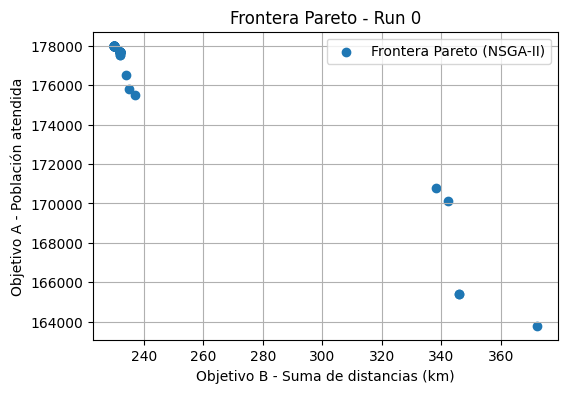

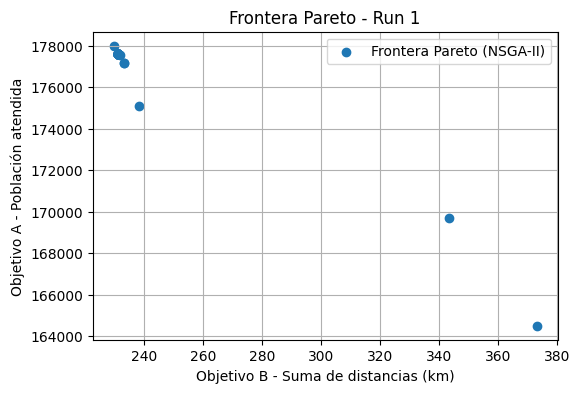

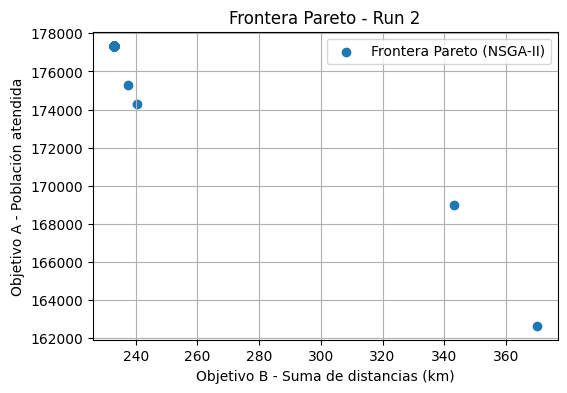

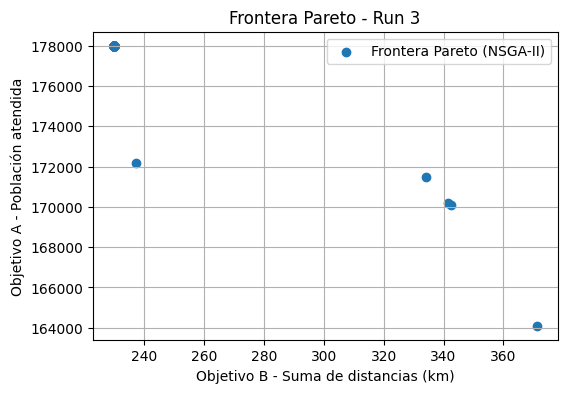

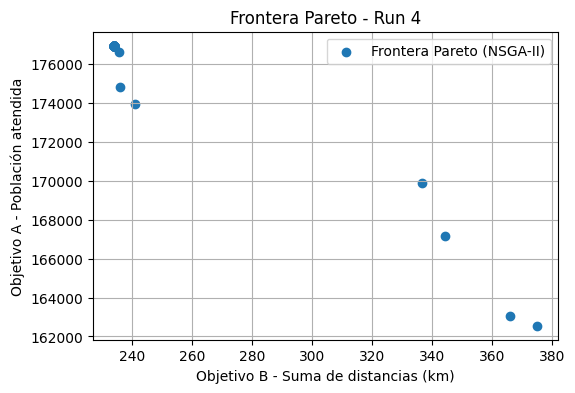

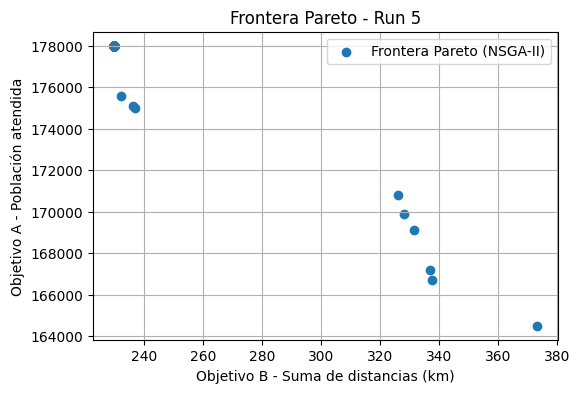

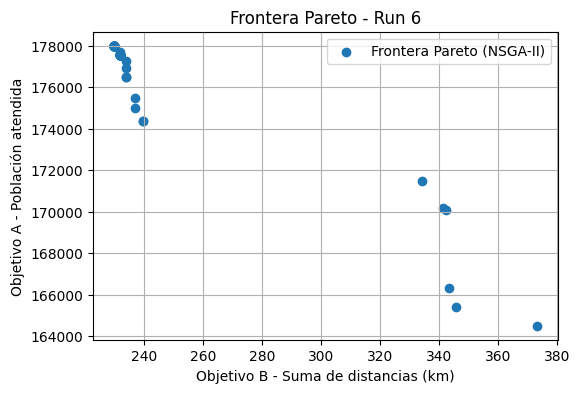

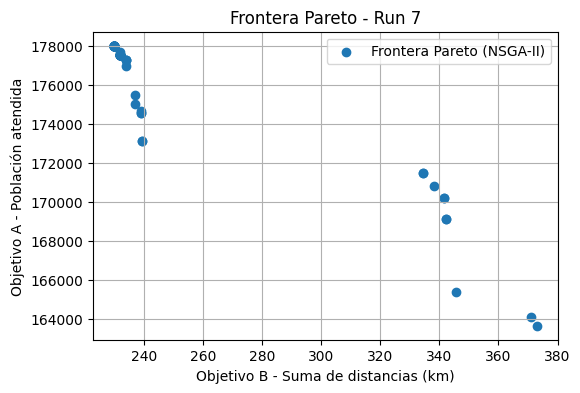

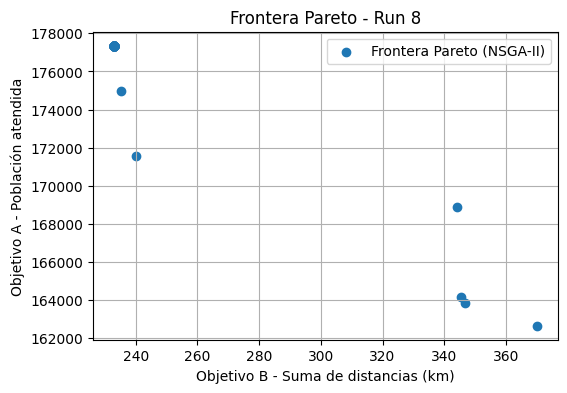

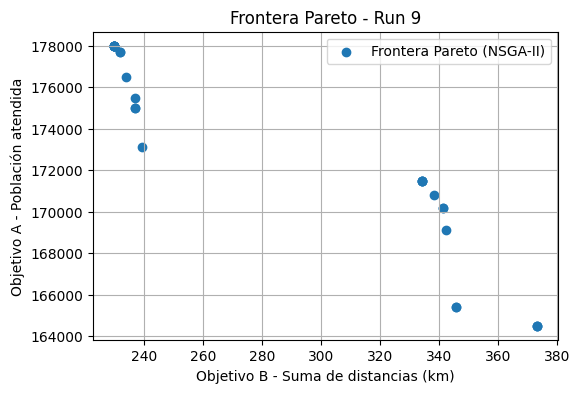

In [38]:
for idx, row in df_resultados_multi.iterrows():
    fitnesses = row['fitnesses']
    x = fitnesses[:, 0]
    y = fitnesses[:, 1]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label="Frontera Pareto (NSGA-II)")
    plt.xlabel('Objetivo B - Suma de distancias (km)')
    plt.ylabel('Objetivo A - Población atendida')
    plt.title(f"Frontera Pareto - Run {row['run']}")
    plt.legend()
    plt.grid(True)
    plt.show()

Se eliminan los cromosomas que representan a una misma solución dentro de cada ejecución y se hace una validación de la restricción de que las localizaciones deben estar alejadas entre ellas a más de 1 km de distancia.

In [39]:
individual_data = []

for _, row in df_resultados_multi.iterrows():
    fitnesses = row['fitnesses']
    chromosomes = row['chromosomes']

    for fitness, chromosome in zip(fitnesses, chromosomes):
        individual_data.append({
            'crossover': row['crossover'],
            'mutation': row['mutation'],
            'selection_parents': row['selection_parents'],
            'run': row['run'],
            'suma de distancias (km)': fitness[0],
            'poblacion atendida': fitness[1],
            'chromosome': [int(gene) for gene in chromosome]
        })

df_individuals_multi = pd.DataFrame(individual_data)

df_individuals_multi['chromosome'] = df_individuals_multi['chromosome'].apply(lambda x: tuple(sorted(x)))
df_individuals_multi = df_individuals_multi.drop_duplicates(subset=['run','chromosome'])
df_individuals_multi['chromosome'] = df_individuals_multi['chromosome'].apply(lambda x: list(sorted(x)))
df_individuals_multi['<1km'] = df_individuals_multi['chromosome'].apply(lambda x: has_close_pairs(x, localizationsPool))
df_individuals_multi = df_individuals_multi[['run','suma de distancias (km)','poblacion atendida','chromosome','<1km']]
print(f"""De las soluciones encontradas, {len(df_individuals_multi[df_individuals_multi['<1km']==True])} soluciones no cumplen con la restricción""")
df_individuals_multi.head()

De las soluciones encontradas, 0 soluciones no cumplen con la restricción


,run,suma de distancias (km),poblacion atendida,chromosome,<1km
0,0,231.812869,177700.0,"[2, 14, 15, 16, 19, 22, 24, 50, 55, 60]",False
3,0,229.870017,178000.0,"[2, 14, 15, 16, 19, 22, 23, 50, 55, 60]",False
10,0,338.251115,170800.0,"[2, 14, 15, 16, 19, 23, 38, 50, 55, 60]",False
13,0,232.048069,177550.0,"[2, 14, 15, 16, 18, 19, 23, 50, 55, 60]",False
20,0,234.079937,176500.0,"[2, 14, 15, 16, 19, 23, 25, 50, 55, 60]",False


Se muestra las 10 primeras soluciones únicas de todas las fronteras de pareto, ordenadas de forma descendente según la población atendida

In [40]:
df_individuals_multi[['suma de distancias (km)','poblacion atendida','chromosome','<1km']].drop_duplicates(subset=['chromosome']).sort_values(by='poblacion atendida', ascending=False).head(10)

,suma de distancias (km),poblacion atendida,chromosome,<1km
3,229.870017,178000.0,"[2, 14, 15, 16, 19, 22, 23, 50, 55, 60]",False
0,231.812869,177700.0,"[2, 14, 15, 16, 19, 22, 24, 50, 55, 60]",False
100,231.166268,177600.0,"[2, 14, 15, 16, 19, 22, 23, 49, 55, 60]",False
13,232.048069,177550.0,"[2, 14, 15, 16, 18, 19, 23, 50, 55, 60]",False
200,232.899909,177350.0,"[3, 11, 12, 15, 16, 20, 23, 50, 55, 60]",False
615,233.924458,177250.0,"[2, 14, 15, 16, 18, 19, 24, 50, 55, 60]",False
117,233.345609,177150.0,"[2, 14, 15, 16, 18, 19, 23, 49, 55, 60]",False
401,234.023281,176950.0,"[3, 13, 15, 16, 17, 20, 23, 50, 55, 60]",False
620,233.927526,176950.0,"[2, 11, 15, 16, 18, 19, 23, 50, 55, 60]",False
463,235.907567,176650.0,"[3, 13, 15, 16, 17, 20, 24, 50, 55, 60]",False


Se muestra las 10 primeras soluciones únicas de todas las fronteras de pareto, ordenadas de forma descendente según la suma de distancias (km)

In [41]:
df_individuals_multi[['suma de distancias (km)','poblacion atendida','chromosome','<1km']].drop_duplicates(subset=['chromosome']).sort_values(by='suma de distancias (km)', ascending=False).head(10)

,suma de distancias (km),poblacion atendida,chromosome,<1km
434,374.832065,162550.0,"[3, 13, 15, 16, 17, 20, 28, 50, 55, 60]",False
107,372.987928,164500.0,"[2, 14, 15, 16, 19, 23, 28, 50, 55, 60]",False
798,372.896708,163650.0,"[2, 14, 15, 16, 18, 23, 28, 50, 55, 60]",False
78,372.037230,163800.0,"[2, 14, 15, 16, 19, 24, 29, 50, 55, 60]",False
318,371.056127,164100.0,"[2, 14, 15, 16, 19, 23, 29, 50, 55, 60]",False
243,369.894426,162650.0,"[3, 11, 15, 16, 20, 23, 29, 50, 55, 60]",False
487,365.988200,163050.0,"[3, 13, 15, 16, 20, 23, 29, 50, 55, 60]",False
880,346.879011,163850.0,"[3, 11, 12, 15, 16, 20, 31, 50, 55, 60]",False
52,345.811674,165400.0,"[2, 14, 15, 16, 19, 23, 31, 50, 55, 60]",False
815,345.388353,164150.0,"[11, 12, 15, 16, 20, 23, 31, 50, 55, 60]",False


Se muestra las distintas soluciones encontradas en la Frontera de Pareto de la ejecución 7

In [43]:
df_individuals_multi[df_individuals_multi['run']==7].sort_values(by='poblacion atendida', ascending=False)

,run,suma de distancias (km),poblacion atendida,chromosome,<1km
701,7,229.870017,178000.0,"[2, 14, 15, 16, 19, 22, 23, 50, 55, 60]",False
733,7,231.812869,177700.0,"[2, 14, 15, 16, 19, 22, 24, 50, 55, 60]",False
702,7,232.048069,177550.0,"[2, 14, 15, 16, 18, 19, 23, 50, 55, 60]",False
732,7,233.924458,177250.0,"[2, 14, 15, 16, 18, 19, 24, 50, 55, 60]",False
716,7,233.927526,176950.0,"[2, 11, 15, 16, 18, 19, 23, 50, 55, 60]",False
780,7,236.897666,175500.0,"[2, 14, 15, 16, 19, 23, 26, 50, 55, 60]",False
790,7,237.051374,175000.0,"[2, 14, 15, 16, 19, 22, 23, 47, 55, 60]",False
750,7,239.203244,174650.0,"[2, 14, 15, 16, 18, 23, 26, 50, 55, 60]",False
737,7,239.230894,174550.0,"[2, 14, 15, 16, 18, 19, 23, 47, 55, 60]",False
700,7,239.306982,173100.0,"[2, 14, 15, 16, 19, 23, 27, 50, 55, 60]",False
